<a href="https://colab.research.google.com/github/Eddiebee/computer_vision_classification_models/blob/main/Is_bird_computer_vision_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00


What seemed to be an outrageous joke years back can be acheived in just few minutes, using entirely free resources.

*The basic steps we'll take are:*


1.   Use DuckDuckGo to search for images of "bird photos"
2.   Use DuckDuckGo to search images of "forest photos"
3. Fine-tune a pretrained neural network to recognise these two groups.
4. Try running this model on a picture of a bird and see if it works.



# **Step 1: Download images of birds and non-birds**

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results=max_images)).itemgot('image')


We'll start by searching for a bird photo and see the kind of result we get.

In [4]:
# first we'll get URLs from the search
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg'

...and then download a URL and take a look at it:

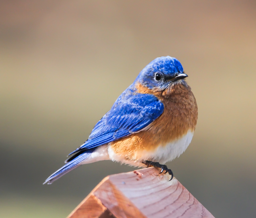

In [6]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
img = Image.open(dest)
img.to_thumb(256, 256)


Searching for 'forest photos'


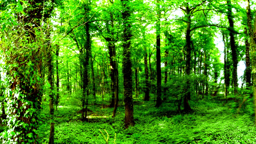

In [7]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=True)
Image.open('forest.jpg').to_thumb(256, 256)

In [9]:
searches = 'forest', 'bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  sleep(0) # Pause between searches to avoid over-loading server
  download_images(dest, urls=search_images(f'{o} sun photo'))
  sleep(10)
  download_images(dest, urls=search_images(f'{o} shade photo'))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o) 


Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


# **Step 2: Train our model**


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

To train a model, we'll need `DataLoader`, which is an object that contains a _training set_ (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a DataBlock, and view sample images from it.

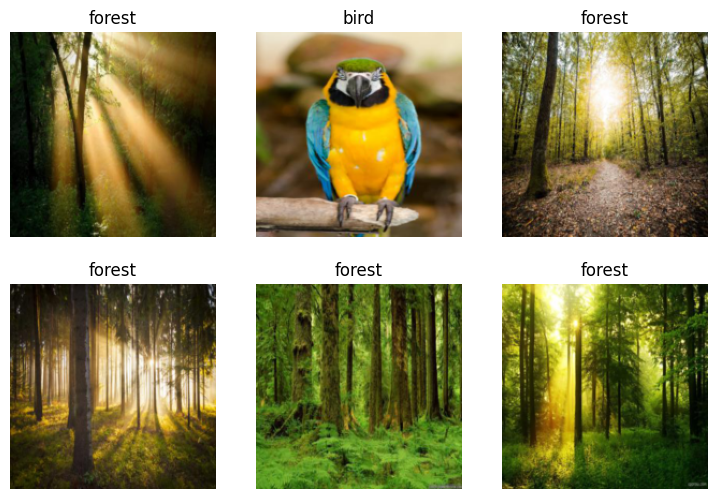

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.957559,0.455442,0.136364,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.175932,0.100433,0.022727,00:23
1,0.094735,0.010888,0.000000,00:23
2,0.060957,0.011129,0.000000,00:24


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the _pretrained model_), and adjusting the weights a little bit so that the model learns to recognise your particular dataset.

# **Step 3: Use our model (and build your own!)**

In [14]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


**Wow!**